# **Import Library**

In [ ]:
pip install unidecode emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 10.7 MB/s eta 0:00:00


In [ ]:
pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 37.2 MB/s eta 0:00:00


In [ ]:
import os
import re
import json
import time
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from wordcloud import WordCloud

import kagglehub
from kagglehub import KaggleDatasetAdapter

from collections import Counter
from unidecode import unidecode
import emoji

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
# from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sentence_transformers import SentenceTransformer
import faiss

import warnings
warnings.filterwarnings("ignore")

# **Load Dataset**

In [ ]:
df = kagglehub.dataset_load(
            KaggleDatasetAdapter.PANDAS,
            "suchintikasarkar/sentiment-analysis-for-mental-health",
            "Combined Data.csv",
        )
df.head()

Unnamed: 0                                          statement   status
0           0                                         oh my gosh  Anxiety
1           1  trouble sleeping, confused mind, restless hear...  Anxiety
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3           3  I've shifted my focus to something else but I'...  Anxiety
4           4  I'm restless and restless, it's been a month n...  Anxiety

# **Data Processing**

In [ ]:
df.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         53043 non-null  int64 
 1   statement  52681 non-null  object
 2   status     53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [ ]:
# kolom pertama jadiin index
df.set_index('id', inplace=True)
df.describe()

statement  status
count               52681   53043
unique              51073       7
top     what do you mean?  Normal
freq                   22   16351

In [ ]:
df.reset_index(inplace=True)
df.isna().sum()

id             0
statement    362
status         0
dtype: int64

In [ ]:
# Baris data NaN
df[df.isna().any(axis=1)]

id statement   status
293      293       NaN  Anxiety
572      572       NaN  Anxiety
595      595       NaN  Anxiety
1539    1539       NaN   Normal
2448    2448       NaN   Normal
...      ...       ...      ...
52838  52838       NaN  Anxiety
52870  52870       NaN  Anxiety
52936  52936       NaN  Anxiety
53010  53010       NaN  Anxiety
53031  53031       NaN  Anxiety

[362 rows x 3 columns]

In [ ]:
# Hapus baris NaN
df.dropna(inplace=True)
df.isna().sum()

id           0
statement    0
status       0
dtype: int64

In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df[df["statement"].str.strip()==""]

Empty DataFrame
Columns: [id, statement, status]
Index: []

In [ ]:
df.reset_index(drop=True, inplace=True)
df

id                                          statement   status
0          0                                         oh my gosh  Anxiety
1          1  trouble sleeping, confused mind, restless hear...  Anxiety
2          2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3          3  I've shifted my focus to something else but I'...  Anxiety
4          4  I'm restless and restless, it's been a month n...  Anxiety
...      ...                                                ...      ...
52676  53038  Nobody takes me seriously I’ve (24M) dealt wit...  Anxiety
52677  53039  selfishness  "I don't feel very good, it's lik...  Anxiety
52678  53040  Is there any way to sleep better? I can't slee...  Anxiety
52679  53041  Public speaking tips? Hi, all. I have to give ...  Anxiety
52680  53042  I have really bad door anxiety! It's not about...  Anxiety

[52681 rows x 3 columns]

In [ ]:
# Count value kolom status
df['status'].value_counts()

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64

# **Exploratory Data Analysis**

In [ ]:
# Hitung distribusi kategori
fig = px.pie(
    df,
    names="status",
    title="Distribusi Status Mental Health"
)

# Tambah label persentase
fig.update_traces(
    textinfo="percent+label",
    hovertemplate="<b>%{label}</b><br>Jumlah: %{value}<br>Persentase: %{percent}"
    )

fig.show()

In [ ]:
# Hitung panjang teks
df["text_length"] = df["statement"].apply(len)

# Visualisasi boxplot
fig = px.box(
    df,
    x="status",
    y="text_length",
    # points="all",  # tampilkan semua titik data di atas boxplot
    title="Distribusi Panjang Teks berdasarkan Status",
    # labels={"status": "Status", "text_length": "Text Length"}
)

fig.show()

In [ ]:
# Hitung rata-rata per status
avg_len = df.groupby("status")["text_length"].mean().reset_index()

# Visualisasi bar chart
fig = px.bar(
    avg_len,
    x="status",
    y="text_length",
    title="Rata-rata Panjang Teks per Status",
    labels={"status": "Status", "text_length": "Rata-rata Panjang Teks"},
    text=avg_len["text_length"].round(1)  # tampilkan nilai di atas bar
)

fig.update_traces(textposition="inside")
fig.show()

In [ ]:
df["n_tokens"] = df["statement"].apply(lambda s: len(s.split()))
# Visualisasi boxplot
fig = px.box(
    df,
    x="status",
    y="n_tokens",
    # points="all",  # tampilkan semua titik data di atas boxplot
    title="Distribusi Jumlah Kata dalam Statement berdasarkan Status",
    # labels={"status": "Status", "text_length": "Text Length"}
)

fig.show()

In [ ]:
# Hitung rata-rata per status
avg_token = df.groupby("status")["n_tokens"].mean().reset_index()

# Visualisasi bar chart
fig = px.bar(
    avg_token,
    x="status",
    y="n_tokens",
    title="Rata-rata Jumlah Kata dalam Statement berdasarkan Status",
    labels={"status": "Status", "n_tokens": "Rata-rata Jumlah Kata"},
    text=avg_token["n_tokens"].round(1)  # tampilkan nilai di atas bar
)

fig.update_traces(textposition="inside")
fig.show()

In [ ]:
MENTAL_STATUS = df['status'].unique()

# Contoh teks per label
for lab in MENTAL_STATUS:
    ex = df[df["status"]==lab].head(2)["statement"].tolist()
    if ex:
        print(f"\n-- Examples ({lab}) --")
        for t in ex:
            print("•", t[:200].replace("\n", " "))


-- Examples (Anxiety) --
• oh my gosh
• trouble sleeping, confused mind, restless heart. All out of tune

-- Examples (Normal) --
• Gr gr dreaming of ex crush to be my game, God
• wkwkwk what a joke

-- Examples (Depression) --
• I recently went through a breakup and she said she still wants to be friends so I said I can try doing that but when she talks to me about things it always hurts. I just want to lose feelings so all t
• I do not know how to navigate these feelings, not that its a new feeling by any stretch. I just do not understand how I can go on from being so pleasantly fine to suicidal and self loathing within in 

-- Examples (Suicidal) --
• I am so exhausted of this. Just when I think I can finally rest, just when I think maybe things are starting to settle, another hurdle comes flying at me. This month alone we found out my mum could be
• I am 20 year old with some good friends but I am just tired a had a problem with bullying when I was little and that hit me hard but 

In [ ]:
# Top words per class (simple TF count, stopword naive)
STOP = set("""
a an the i me my we you he she it they them our your is are was were be been am to for of and in on at with from by this that these those as not no do does did have has had will would should could can can't don't isn't wasn't won't it's i'm you're we're
""".split())

def top_words(statement, topk=10):
    tokens = []
    for s in statement:
        s = s.lower()
        s = re.sub(r"http\S+|www\.\S+","", s)
        s = re.sub(r"[^a-z\s]", " ", s)
        arr = [w for w in s.split() if w not in STOP and len(w)>2]
        tokens.extend(arr)
    return Counter(tokens).most_common(topk)

for lab in MENTAL_STATUS:
    rows = df[df["status"]==lab]["statement"].tolist()
    if rows:
        print(f"\nTop words for '{lab}':")
        print(top_words(rows, 10))


Top words for 'Anxiety':
[('but', 5338), ('anxiety', 3835), ('just', 3381), ('like', 3296), ('about', 3096), ('feel', 2286), ('out', 2194), ('all', 2126), ('when', 2103), ('now', 1999)]

Top words for 'Normal':
[('but', 1990), ('just', 1285), ('like', 1274), ('what', 1235), ('want', 1123), ('don', 1105), ('her', 1063), ('about', 980), ('out', 891), ('when', 879)]

Top words for 'Depression':
[('but', 25442), ('just', 23323), ('like', 18325), ('feel', 16570), ('want', 12147), ('all', 12101), ('life', 11337), ('know', 10867), ('about', 10709), ('because', 10440)]

Top words for 'Suicidal':
[('but', 14897), ('just', 14438), ('want', 10660), ('like', 9138), ('cannot', 7888), ('life', 7856), ('myself', 7781), ('all', 7584), ('feel', 7532), ('know', 6573)]

Top words for 'Stress':
[('but', 2627), ('like', 1731), ('just', 1706), ('stress', 1531), ('about', 1379), ('feel', 1341), ('out', 1326), ('what', 1290), ('don', 1219), ('get', 1208)]

Top words for 'Bipolar':
[('but', 4761), ('just', 34

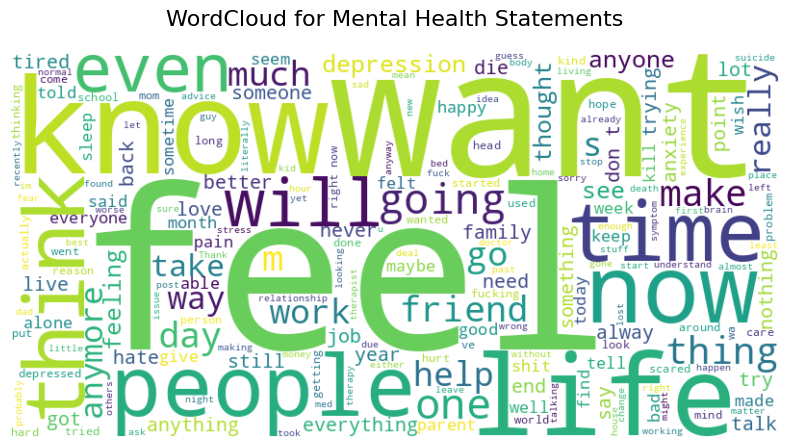

In [ ]:
# Gabungkan semua statement jadi 1 teks
text = " ".join(df["statement"])

# Buat word cloud
wc = WordCloud(width=800, height=400, background_color="white").generate(text)

# Visualisasi
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation="bilinear")
plt.title("WordCloud for Mental Health Statements", fontsize=16, pad=20)
plt.axis("off")
plt.show()

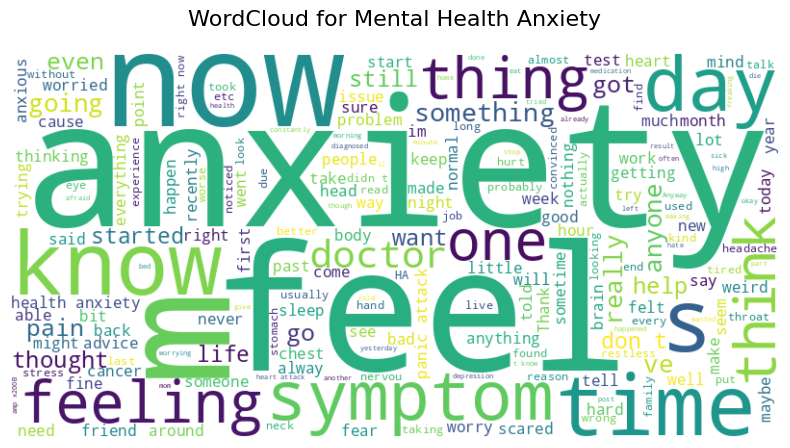

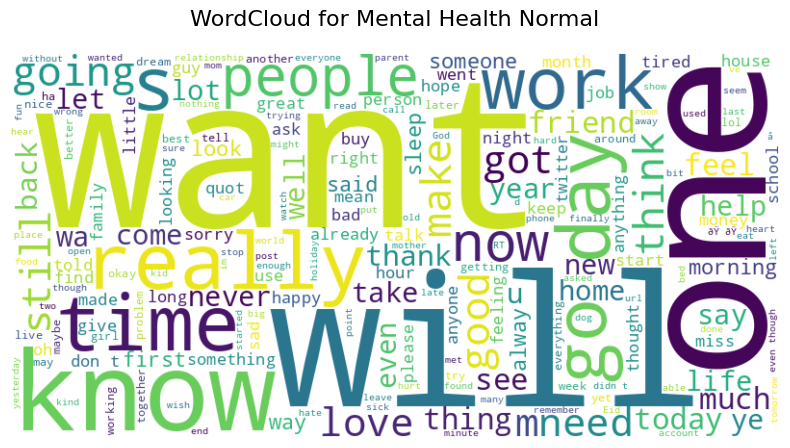

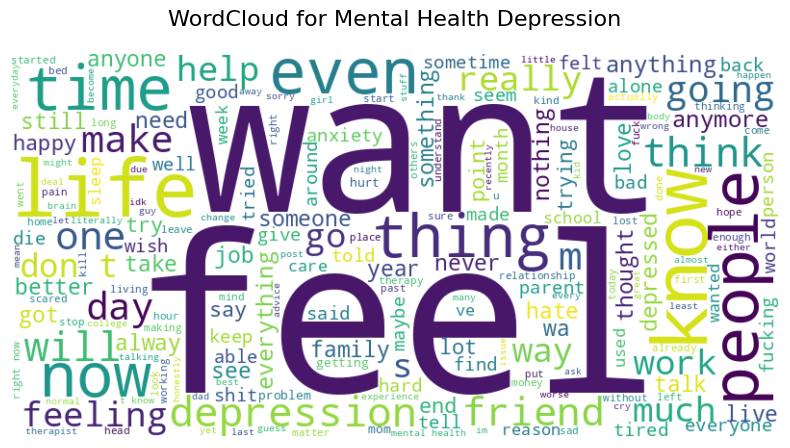

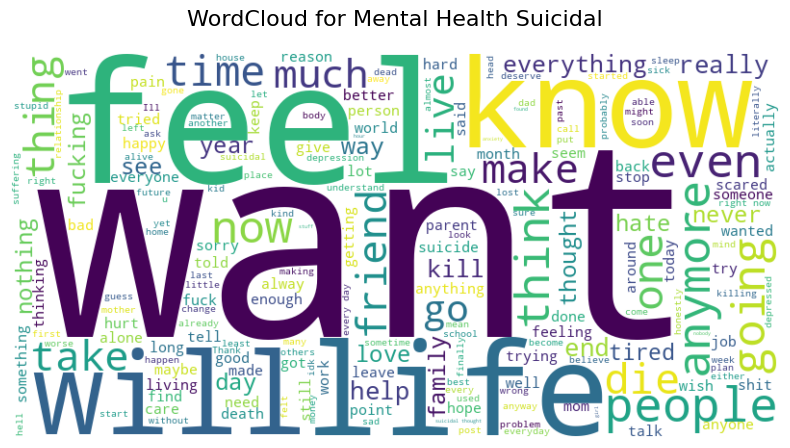

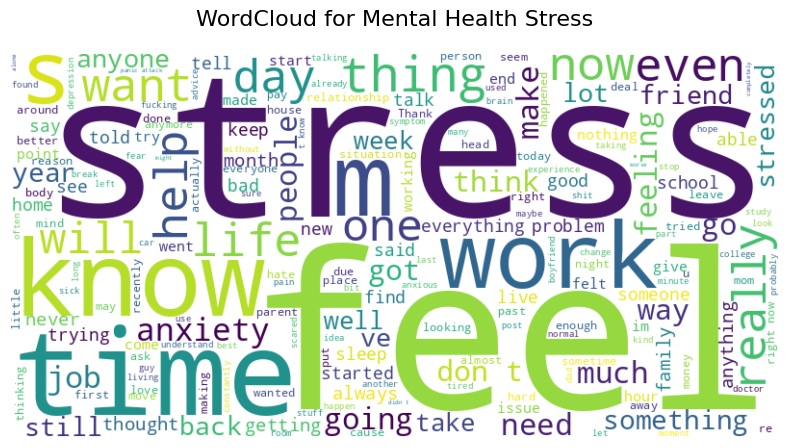

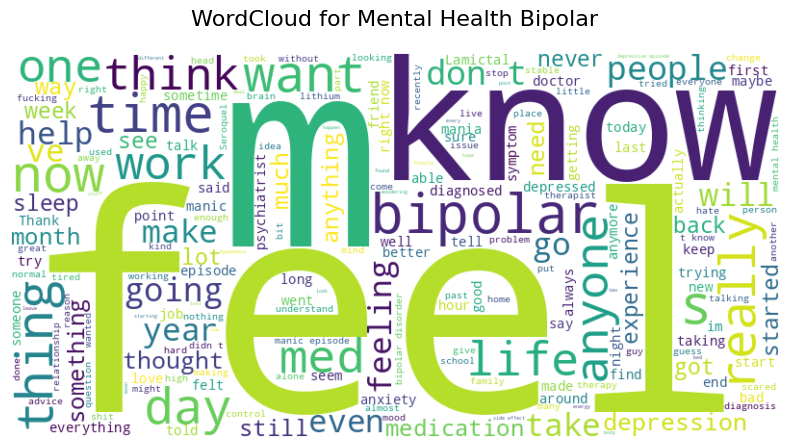

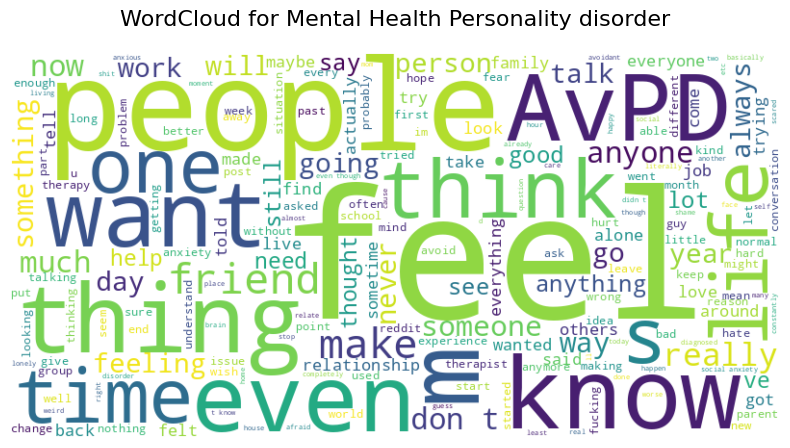

In [ ]:
for status in MENTAL_STATUS:
    text = " ".join(df[df["status"] == status]["statement"])

    wc = WordCloud(
        width=800,
        height=400,
        background_color="white",
        # colormap="viridis"
    ).generate(text)

    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud for Mental Health {status}", fontsize=16, pad=20)
    plt.show()
    print()

# **Data Processing Cont.**

In [ ]:
# Config
SEED = 42
np.random.seed(SEED)

RAW_ID_COL = "id"
RAW_TEXT_COL = "statement"
RAW_LABEL_COL = "status"

SAMPLE_INPUT_PATH = "sample_input.csv"  # input TANPA label utk verifikasi lokal
SUBMISSION_PATH = "submission.csv"

In [ ]:
df = df.rename(columns={RAW_ID_COL:"id", RAW_TEXT_COL:"text", RAW_LABEL_COL:"label"})

# normalisasi label
df["label"] = df["label"].str.strip().str.lower()

In [ ]:
# TEXT PREPROCESS FUNCTION (light)
def clean_text(s: str):
    s = unidecode(s)                               # remove accents
    s = emoji.replace_emoji(s, replace=" ")        # strip emoji
    s = s.lower()
    s = re.sub(r"http\S+|www\.\S+"," ", s)         # remove urls
    s = re.sub(r"@[A-Za-z0-9_]+"," ", s)           # remove mentions
    s = re.sub(r"#"," ", s)                        # drop '#'
    s = re.sub(r"\s+"," ", s).strip()
    return s

df["text_clean"] = df["text"].apply(clean_text)
df[["id","label","text_clean"]].head()

# **Split Data**

In [ ]:
train_df, val_df = train_test_split(
    df[["id","label","text_clean"]],
    test_size=0.2, random_state=SEED, stratify=df["label"]
)
print("Train:", train_df.shape, " Val:", val_df.shape)

Train: (42144, 3)  Val: (10537, 3)


In [ ]:
# Label encoder (string -> int)
lab_enc = LabelEncoder()
train_y = lab_enc.fit_transform(train_df["label"])
val_y   = lab_enc.transform(val_df["label"])
print("Classes:", list(lab_enc.classes_))

Classes: ['anxiety', 'bipolar', 'depression', 'normal', 'personality disorder', 'stress', 'suicidal']


# **SBERT EMBEDDINGS (Use Hugging Face model)**

In [ ]:
embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

Xtr_emb = embedder.encode(
    train_df["text_clean"].tolist(),
    normalize_embeddings=True, show_progress_bar=True
)
Xval_emb = embedder.encode(
    val_df["text_clean"].tolist(),
    normalize_embeddings=True, show_progress_bar=True
)

print("Embedding shape:", Xtr_emb.shape)  # (n_samples, 384)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1317 [00:00<?, ?it/s]

Batches:   0%|          | 0/330 [00:00<?, ?it/s]

Embedding shape: (42144, 384)


In [ ]:
def eval_and_report(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    print(f"\n=== {model_name} ===")
    print("Accuracy :", round(acc,4))
    print("F1-macro :", round(f1m,4))
    print(classification_report(y_true, y_pred, target_names=lab_enc.classes_))
    return acc, f1m

results = []

# **Logistic Regression**

In [ ]:
clf_log = LogisticRegression(
    max_iter=1000, multi_class="multinomial", n_jobs=None, random_state=SEED
)
clf_log.fit(Xtr_emb, train_y)
pred_log = clf_log.predict(Xval_emb)
acc_log, f1_log = eval_and_report(val_y, pred_log, "SBERT + Logistic Regression")
results.append(("SBERT+LogReg", acc_log, f1_log))


=== SBERT + Logistic Regression ===
Accuracy : 0.7597
F1-macro : 0.7042
                      precision    recall  f1-score   support

             anxiety       0.79      0.75      0.77       768
             bipolar       0.84      0.73      0.78       556
          depression       0.69      0.74      0.71      3081
              normal       0.87      0.94      0.91      3269
personality disorder       0.75      0.44      0.55       215
              stress       0.63      0.51      0.57       517
            suicidal       0.67      0.61      0.64      2131

            accuracy                           0.76     10537
           macro avg       0.75      0.67      0.70     10537
        weighted avg       0.76      0.76      0.76     10537



# **Linear SVM**

In [ ]:
clf_svm = LinearSVC(random_state=SEED)
clf_svm.fit(Xtr_emb, train_y)
pred_svm = clf_svm.predict(Xval_emb)
acc_svm, f1_svm = eval_and_report(val_y, pred_svm, "SBERT + Linear SVM")
results.append(("SBERT+LinearSVM", acc_svm, f1_svm))


=== SBERT + Linear SVM ===
Accuracy : 0.7593
F1-macro : 0.7012
                      precision    recall  f1-score   support

             anxiety       0.79      0.76      0.77       768
             bipolar       0.84      0.74      0.79       556
          depression       0.69      0.74      0.71      3081
              normal       0.86      0.95      0.90      3269
personality disorder       0.77      0.42      0.55       215
              stress       0.66      0.46      0.54       517
            suicidal       0.67      0.62      0.64      2131

            accuracy                           0.76     10537
           macro avg       0.76      0.67      0.70     10537
        weighted avg       0.76      0.76      0.75     10537



# **XGBoost**

In [ ]:
num_class = len(lab_enc.classes_)
clf_xgb = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=num_class,
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=SEED,
    n_jobs=-1
)
clf_xgb.fit(Xtr_emb, train_y)
pred_xgb = clf_xgb.predict(Xval_emb)
acc_xgb, f1_xgb = eval_and_report(val_y, pred_xgb, "SBERT + XGBoost")
results.append(("SBERT+XGBoost", acc_xgb, f1_xgb))


=== SBERT + XGBoost ===
Accuracy : 0.7739
F1-macro : 0.7334
                      precision    recall  f1-score   support

             anxiety       0.84      0.78      0.81       768
             bipolar       0.89      0.72      0.80       556
          depression       0.69      0.76      0.72      3081
              normal       0.88      0.95      0.92      3269
personality disorder       0.89      0.49      0.63       215
              stress       0.74      0.51      0.60       517
            suicidal       0.68      0.62      0.65      2131

            accuracy                           0.77     10537
           macro avg       0.80      0.69      0.73     10537
        weighted avg       0.77      0.77      0.77     10537



# **Evaluasi**

In [ ]:
summary = pd.DataFrame(results, columns=["Model","Accuracy","F1_macro"]).sort_values("F1_macro", ascending=False)
print("\nModel comparison (sorted by F1_macro):")
print(summary)


Model comparison (sorted by F1_macro):
             Model  Accuracy  F1_macro
2    SBERT+XGBoost  0.773939  0.733356
0     SBERT+LogReg  0.759704  0.704210
1  SBERT+LinearSVM  0.759324  0.701159


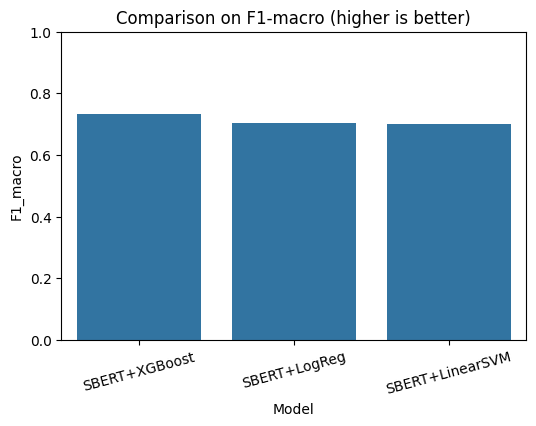

In [ ]:
plt.figure(figsize=(6,4))
sns.barplot(x="Model", y="F1_macro", data=summary)
plt.title("Comparison on F1-macro (higher is better)")
plt.ylim(0,1); plt.xticks(rotation=15)
plt.show()

In [ ]:
best_name = summary.iloc[0]["Model"]
print(">>> Best model:", best_name)

>>> Best model: SBERT+XGBoost


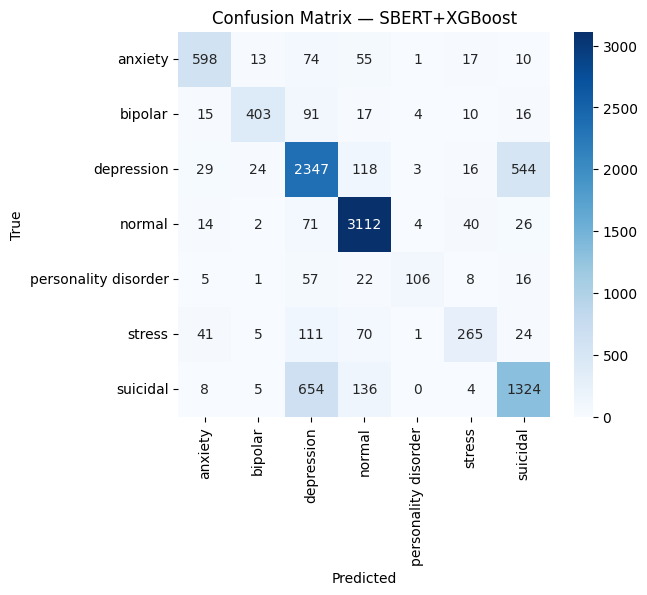

In [ ]:
best_pred = {"SBERT+LogReg": pred_log, "SBERT+LinearSVM": pred_svm, "SBERT+XGBoost": pred_xgb}[best_name]
cm = confusion_matrix(val_y, best_pred, labels=range(num_class))
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=lab_enc.classes_, yticklabels=lab_enc.classes_)
plt.title(f"Confusion Matrix — {best_name}")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

In [ ]:
d = Xtr_emb.shape[1]
index = faiss.IndexFlatIP(d)  # inner product ~ cosine (karena normalized)
index.add(np.array(Xtr_emb).astype("float32"))

In [ ]:
def semantic_search(query_text, k=5):
    q = embedder.encode([clean_text(query_text)], normalize_embeddings=True).astype("float32")
    D, I = index.search(q, k)
    hits = train_df.iloc[I[0]][["id","label","text_clean"]].copy()
    hits["score"] = D[0]
    return hits

In [ ]:
print("\nSemantic Search Demo:")
display(semantic_search("I feel hopeless and want to die", k=5))
display(semantic_search("Feeling calm and okay today", k=5))


Semantic Search Demo:


id       label                                         text_clean  \
16892  16892    suicidal  i want to give up. i want to die. my life is h...   
23507  23507    suicidal                       i feel so hopeless so lonely   
26271  26271  depression  the feeling never truly goes away. i am destin...   
22632  22632    suicidal                 i want to die so bad i want to die   
13516  13516    suicidal  i want to die. i do not feel like living anymo...   

          score  
16892  0.781322  
23507  0.757217  
26271  0.734811  
22632  0.718607  
13516  0.717892

id       label                                         text_clean  \
100      100     anxiety                    feeling a little anxious today.   
750      750      normal                                feeling happy today   
15890  15890  depression  i know we usually talk about our problems here...   
43982  43982      normal                            feeling ill again today   
43598  43598      normal                   feeling ill and sorry for myself   

          score  
100    0.741687  
750    0.709443  
15890  0.707097  
43982  0.682495  
43598  0.657354

In [ ]:
if not os.path.exists(SAMPLE_INPUT_PATH):
    sample_rows = [
        (1, "I can't sleep and my mind is racing with dark thoughts."),
        (2, "Everything feels normal and I enjoyed my lunch."),
        (3, "I have sudden mood swings, very high then very low."),
        (4, "Constant worry about everything, heart is pounding."),
        (5, "I want to disappear. No point in living."),
        (6, "Feeling okay, got some work done today."),
        (7, "Crying a lot lately, heavy sadness all day."),
        (8, "My thoughts jump quickly, can’t focus, too much energy."),
        (9, "Nervous in social situations, sweaty palms, shaky."),
        (10, "Went for a walk, felt calm and relaxed."),
    ]
    pd.DataFrame(sample_rows, columns=["id","text"]).to_csv(SAMPLE_INPUT_PATH, index=False)
    print(f"Created sample input at {SAMPLE_INPUT_PATH}")
else:
    print(f"Found {SAMPLE_INPUT_PATH}")

Created sample input at sample_input.csv


In [ ]:
sample_df = pd.read_csv(SAMPLE_INPUT_PATH)
assert {"id","text"}.issubset(sample_df.columns), "sample_input.csv must have columns: id,text"

In [ ]:
# pilih model terbaik
best_clf = {
    "SBERT+LogReg": clf_log,
    "SBERT+LinearSVM": clf_svm,
    "SBERT+XGBoost": clf_xgb
}[best_name]

Xs = embedder.encode(sample_df["text"].apply(clean_text).tolist(), normalize_embeddings=True)
pred_ids = best_clf.predict(Xs)
pred_labels = lab_enc.inverse_transform(pred_ids)

submission = pd.DataFrame({"text": sample_df["text"], "label": pred_labels})
submission.to_csv(SUBMISSION_PATH, index=False)
print(f"Saved {SUBMISSION_PATH}")
submission.head()

Saved submission.csv


text       label
0  I can't sleep and my mind is racing with dark ...      normal
1    Everything feels normal and I enjoyed my lunch.      normal
2  I have sudden mood swings, very high then very...  depression
3  Constant worry about everything, heart is poun...     anxiety
4           I want to disappear. No point in living.    suicidal

In [ ]:
import joblib

# pilih model terbaik (berdasarkan Macro-F1)
best_clf = {
    "SBERT+LogReg": clf_log,
    "SBERT+LinearSVM": clf_svm,
    "SBERT+XGBoost": clf_xgb
}[best_name]

# simpan model + label encoder ke file
joblib.dump(best_clf, "best_model.pkl")
joblib.dump(lab_enc, "label_encoder.pkl")

print("Saved best model and label encoder → best_model.pkl, label_encoder.pkl")